# Assignment 1

**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

## Table of contents

1. [Import Libraries](#Import-Libraries)
2. [Get Data](#Get-Data)
3. [A bit of Exploratory Data Analysis (EDA)](#EDA)


## 1. Import Libraries <a name="Import-Libraries"></a>

In [1]:
import warnings
import itertools
import subprocess
import psycopg2

import pandas            as pd
import numpy             as np
import statsmodels.api   as sm
import matplotlib.pyplot as plt
import seaborn           as sns

%matplotlib inline
sns.set()

## 2. Get Data <a name="Get-Data"></a>

We have 2 options here toggled by the 'in_school' variable.
If this variable is set to True we will obtain our data by pulling a JSON object from the heroku webserver.
If it is set to False we will obtain it by first connecting to the Heroku PostgreSQL database and applying a simple SQL querry to that database.

In [2]:
in_school = True

if (True == in_school):
    # Get the data from the web route because school blocks the port used by the database :)
    
    url = 'https://pxl-ss.herokuapp.com/api/temps'
    data = pd.read_json(url, orient='columns')
else:
    # Get the data directly from the database
    
    HEROKU_APP_NAME = "pxl-ss"
    TABLE_NAME = "Temperature"

    conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
    connuri = conn_info.stdout.decode('utf-8').strip()

    engine = create_engine(connuri)
    raw_engine = engine.raw_connection()

    data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)
    

print(data.head())

                      creation_date  id                          place  value
0  2018-11-10T23:38:44.453789+00:00   1  Lat:51.037460, Long: 5.301590  21.48
1  2018-11-10T23:53:53.134313+00:00   2  Lat:51.037460, Long: 5.301590  19.48
2  2018-11-10T23:53:57.457321+00:00   3  Lat:51.037460, Long: 5.301590  20.60
3  2018-11-10T23:56:10.690055+00:00   4  Lat:51.037460, Long: 5.301590  20.45
4  2018-11-10T23:58:49.577553+00:00   5  Lat:51.037460, Long: 5.301590  20.76


### Restructure the data to form a time series

The data we got from our source is has multiple tables we don't care about, we really only care about the 'creation_date' & 'value' column.<br>
We create a new pandas dataframe with only those 2 columns and rename them to a more human readable names: 'dateTime' & 'temperature'.

Afther renaming the columns we will have to convert them to the right data type. datetime for the 'dateTime' column and float for the 'temperature' column.

Since we are aiming to work with a time series we have to set the 'dateTime' column as the index.

In [3]:
# Filter out all the columsn except for 'creation_date' & 'value'
# Rename those columns to 'dateTime' & temperature
df = pd.DataFrame(data, columns = ['creation_date', 'value'])
df.columns = ['dateTime', 'temperature']

# Inspect data
#print(df.info())

# Convert the creation_date column to datetime64
# df['dateTime'] = pd.to_datetime(df['dateTime'])
df['dateTime'] = pd.to_datetime(df.dateTime)
# Convert the value column to float
df['temperature'] = pd.to_numeric(df.temperature)

# Set the dateTime column as index
df.set_index(['dateTime'], inplace=True)

# Inspect data
print(df.head())

                            temperature
dateTime                               
2018-11-10 23:38:44.453789        21.48
2018-11-10 23:53:53.134313        19.48
2018-11-10 23:53:57.457321        20.60
2018-11-10 23:56:10.690055        20.45
2018-11-10 23:58:49.577553        20.76


## 3. A bit of Exploratory Data Analysis (EDA) <a name="EDA"></a>

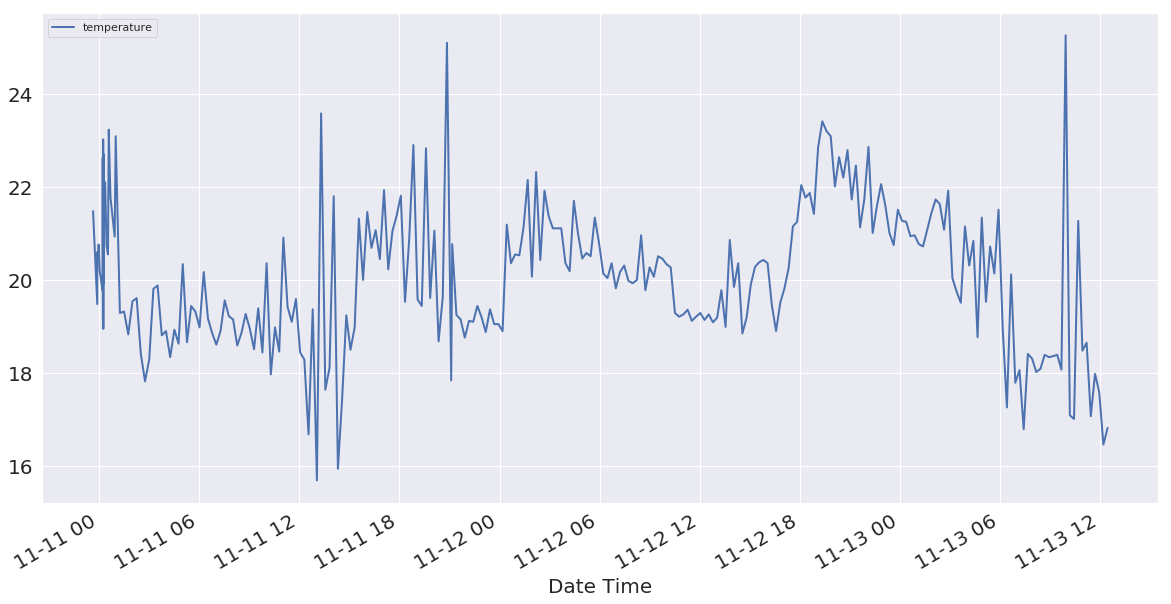

In [4]:
df.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Date Time', fontsize=20);

## Trends and Seasonality in Time Series Data

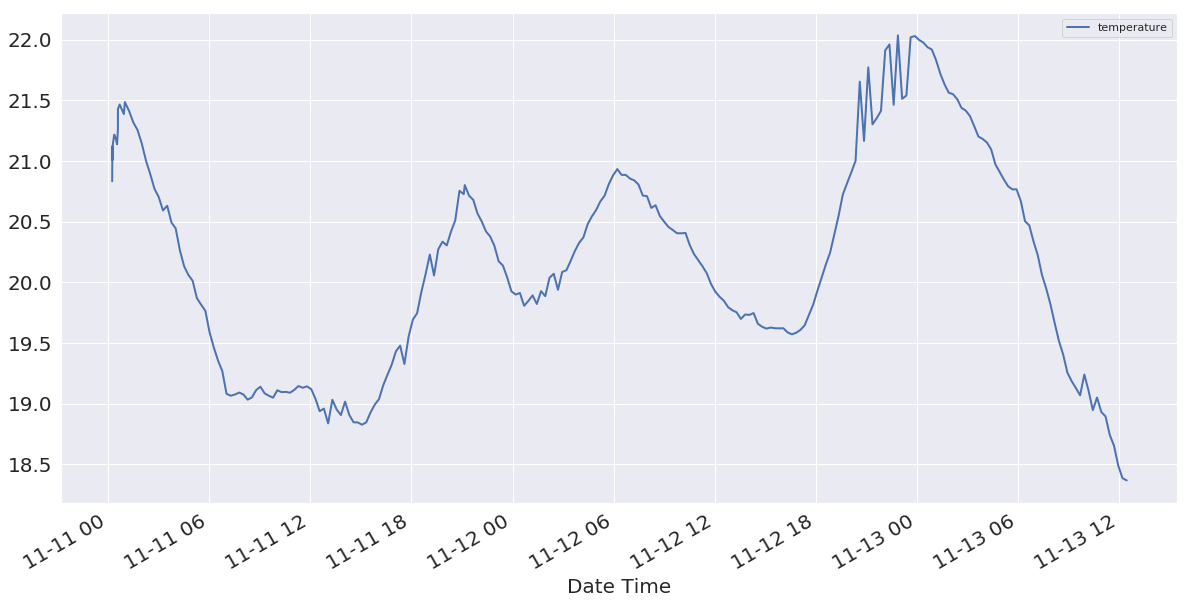

In [5]:
temperature = df[['temperature']]
temperature.rolling(24).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Date Time', fontsize=20);

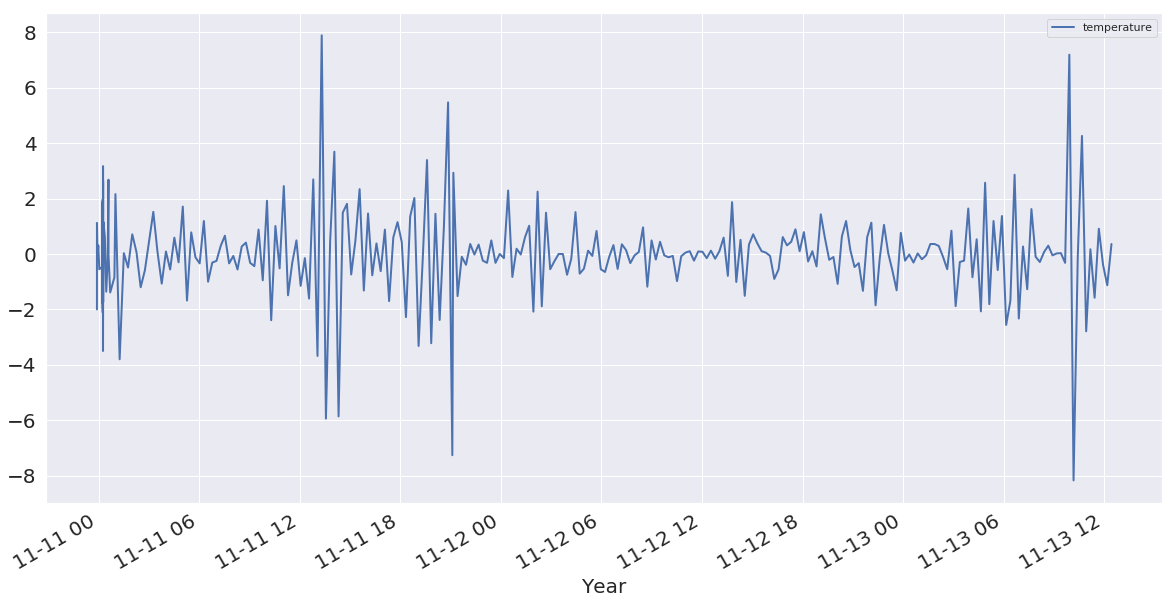

In [6]:
temperature.diff().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [7]:
print(df.diff().corr())

             temperature
temperature          1.0


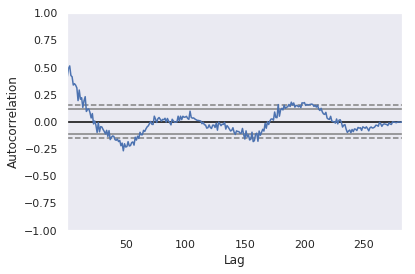

In [8]:
pd.plotting.autocorrelation_plot(df);

/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/bryan/.conda/envs/pxl/lib/python3.6/site

                             ARIMA Model Results                              
Dep. Variable:          D.temperature   No. Observations:                  281
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -449.915
Method:                       css-mle   S.D. of innovations              1.198
Date:                Tue, 13 Nov 2018   AIC                            913.831
Time:                        13:33:51   BIC                            939.299
Sample:                             1   HQIC                           924.045
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0128      0.025     -0.511      0.610      -0.062       0.036
ar.L1.D.temperature    -0.9047      0.060    -15.153      0.000      -1.022      -0.788
ar.L2.D.temperat

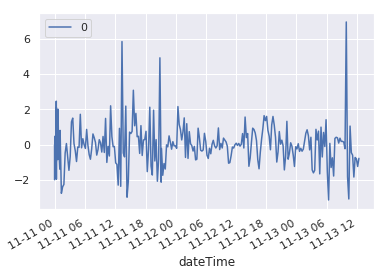

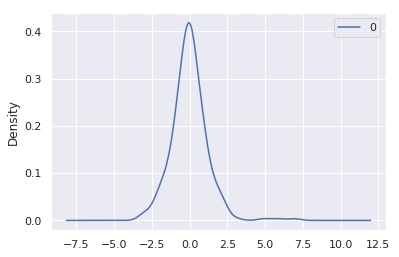

                0
count  281.000000
mean    -0.005641
std      1.202742
min     -3.132567
25%     -0.652010
50%     -0.060854
75%      0.607541
max      6.950574


In [9]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(df, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [10]:
from sklearn.metrics import mean_squared_error

X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/bryan/.conda/envs/pxl/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fut

predicted=19.216251, expected=19.260000
predicted=19.190830, expected=19.090000
predicted=19.180158, expected=19.190000
predicted=19.168634, expected=19.780000
predicted=19.170380, expected=18.990000
predicted=19.328389, expected=20.860000
predicted=19.391180, expected=19.850000
predicted=19.721965, expected=20.360000
predicted=20.073287, expected=18.850000
predicted=19.976410, expected=19.190000
predicted=19.776145, expected=19.900000
predicted=19.402263, expected=20.280000
predicted=19.577419, expected=20.380000
predicted=19.809718, expected=20.430000
predicted=20.057618, expected=20.360000
predicted=20.265844, expected=19.460000
predicted=20.298785, expected=18.900000
predicted=19.999204, expected=19.510000
predicted=19.565095, expected=19.820000
predicted=19.459876, expected=20.260000
predicted=19.593204, expected=21.150000
predicted=19.856852, expected=21.250000
predicted=20.389488, expected=22.040000
predicted=20.932243, expected=21.770000
predicted=21.376354, expected=21.870000


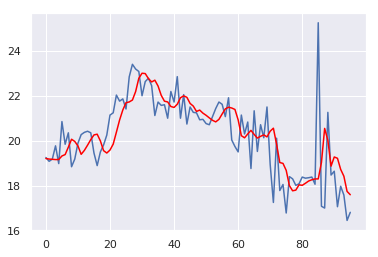

In [11]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [12]:
# specify training data
data = df
# define model configuration
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 12)
# define model
model = SARIMAX(df, order=my_order, seasonal_order=my_seasonal_order)

NameError: name 'SARIMAX' is not defined